In [4]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2,plot_kde_matrix_for_paper
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix
import numpy as np
import matplotlib.pyplot as plt

path = '../../results'
output_path = '../../figures'

f_no_aneuploidy = 'no-aneuploidy'
f_with_aneuploidy = 'basic-prior'
f_prior4 = 'extended-prior' # 0.370941 epsilon #bug it is not 1000 reps, it is 100, rerun
f_neutral = 'neutral-aneuploidy'

## Instruction
### You can jump [loading section](#loading) if you want only to plot figure and the data is already persisted

In [1]:
def sample_from_kde(file_name, t=None, alt_prior=False, size=50000):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, file_name))
    samples, weights = history.get_distribution(m=0, t=t)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    kdesamples = kde.resample(2*size).T
    if alt_prior:
        kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
        criteria = (kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) & (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2)
        w1 = samples['p3_w1']
        w2 = samples['p3_w1']*samples['p4_w2']
        w3 = samples['p3_w1']*samples['p5_w3']
        order_criteria = (1<w1) & (w1<w2) & (w2<w3)
        criteria = criteria & order_criteria
        kdesamples = kdesamples[criteria][:size]
    elif len(samples.columns)==2: #f_no_aneuploidy
        kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', '2n* fitness'])
        criteria = (kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5)
        kdesamples = kdesamples[criteria][:size]
    elif len(samples.columns)==3: #f_neutral
        kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate','trisomy rate', 'fitness'])
        criteria = (kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) & (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2)
        kdesamples = kdesamples[criteria][:size]
    else:
        kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
        criteria = (kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) & (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2)
        order_criteria = (kdesamples['2n+1 fitness'] < kdesamples['2n+1* fitness']) & (kdesamples['2n+1* fitness'] < kdesamples['2n* fitness'])
        criteria = criteria & order_criteria
        kdesamples = kdesamples[criteria][:size]
    return kdesamples, kde

In [50]:
import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1, stopon=3000, fixation=0.95)
N = 6*10**6
reps = 10000

## MAP of model with aneuploidy

In [51]:
%%time
samples, kde = sample_from_kde(f_with_aneuploidy)
p = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                  and x[1]>1e-6 and x[1]<1e-2 else 100000
                                  ,samples.median().values)['x']
p = [p[0],p[1],p[1],*p[2:]] # aneuploidy gain and loss rates are the same
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

CPU times: user 6min 17s, sys: 4.08 s, total: 6min 21s
Wall time: 6min 51s


-0.833558222558

In [52]:
with_aneuploidy = times_p

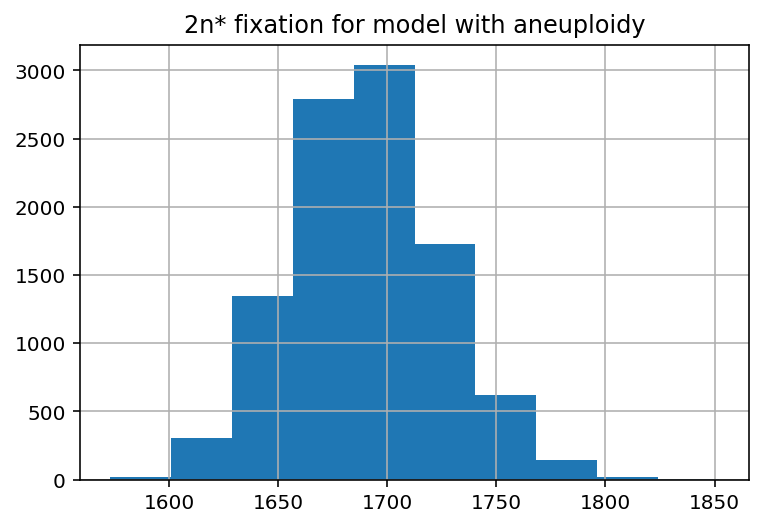

In [53]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model with aneuploidy');

## MAP of model with aneuploidy and delta=0

In [54]:
samples, kde = sample_from_kde(f_with_aneuploidy)
p = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                  and x[1]>1e-6 and x[1]<1e-2 else 100000
                                  ,samples.median().values)['x']
p = [p[0],0,0,*p[2:]]
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

0

In [55]:
with_aneuploidy_delta0 = times_p

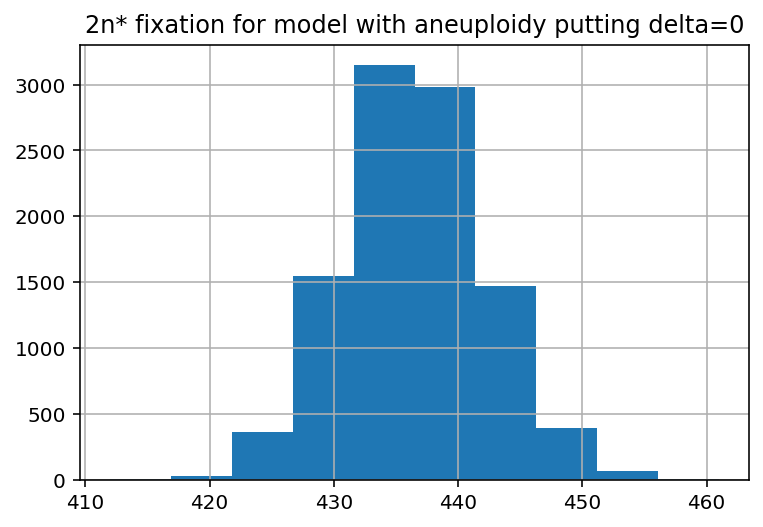

In [56]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model with aneuploidy putting delta=0');

## MAP of model *without* aneuploidy

In [57]:
samples, kde = sample_from_kde(f_no_aneuploidy)
p = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                   else 100000
                                  ,samples.median().values)['x']
p = [p[0],0,0,0,0,p[-1]]
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

0

In [58]:
model.grade_function_no_aneuploidy(times_p)

-0.6593810113704

In [59]:
no_aneuploidy = times_p

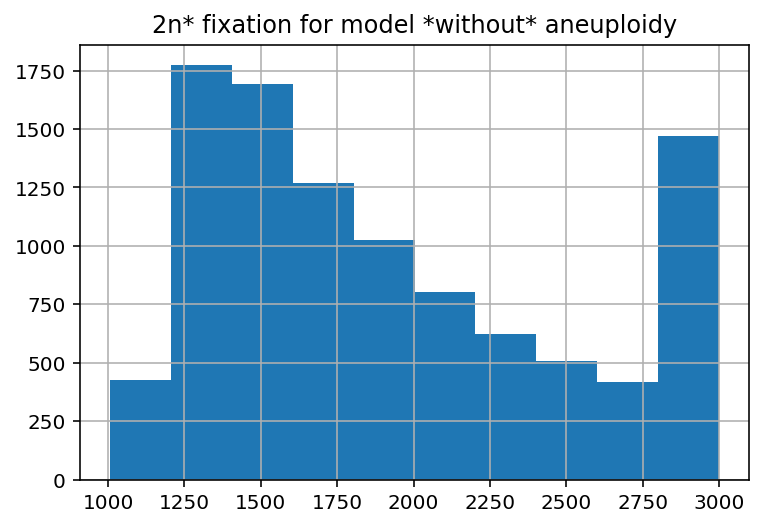

In [60]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model *without* aneuploidy');

## Model with extended prior

In [61]:
%%time
samples, kde = sample_from_kde(f_prior4, t=18, alt_prior=True)
p = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                  and x[1]>1e-6 and x[1]<1e-2 else 100000
                                  ,samples.median().values)['x']
p = [p[0],p[1],p[1],*p[2:]] # aneuploidy gain and loss rates are the same
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

CPU times: user 9min 33s, sys: 4.09 s, total: 9min 37s
Wall time: 9min 57s


-0.0028898578777600825

In [62]:
extended_prior = times_p

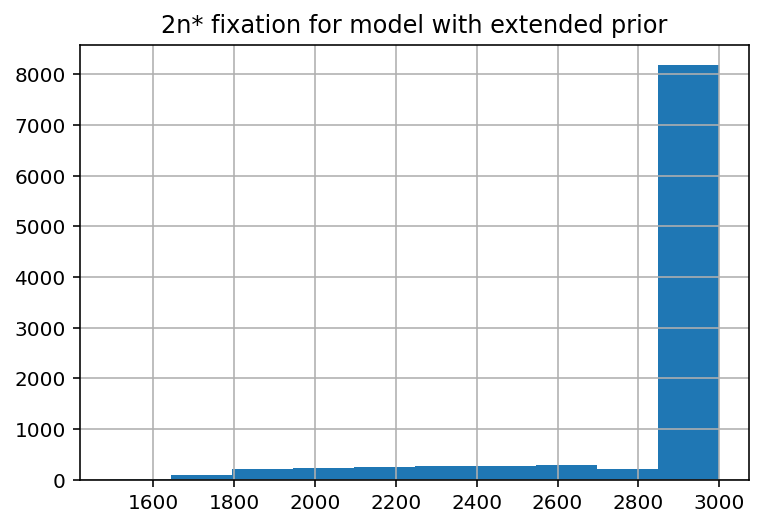

In [63]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model with extended prior');

## Model with neutral aneuploidy (b=c=0)

In [64]:
%%time
samples, kde = sample_from_kde(f_neutral)
p = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                  and x[1]>1e-6 and x[1]<1e-2 else 100000
                                  ,samples.median().values)['x']
p = [p[0],p[1],p[1],1,p[2],p[2]]
times_p = model.run_simulations(N, *p, repetitions=reps, seed=555)
model.grade_function2(times_p)

CPU times: user 5min 47s, sys: 1.55 s, total: 5min 49s
Wall time: 5min 51s


-0.785741331657555

In [65]:
neutral_aneuploidy = times_p

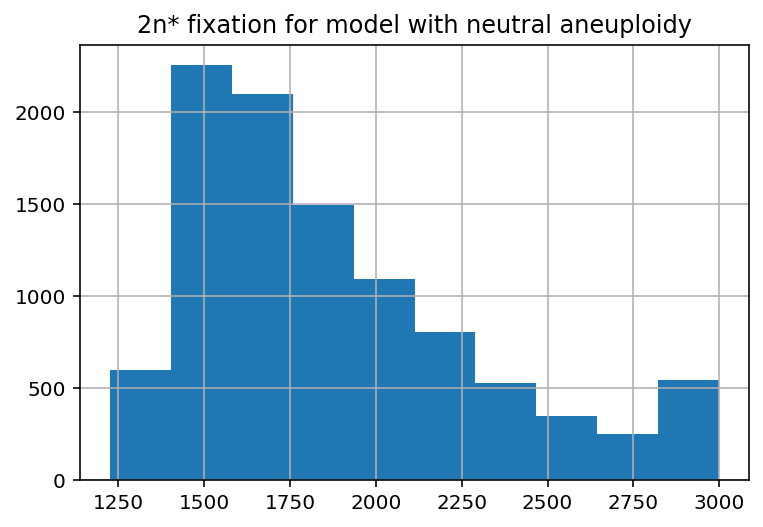

In [66]:
pd.Series(times_p[0]).hist()
plt.title('2n* fixation for model with neutral aneuploidy');

## Persisting result
### uncomment the next line if you need it

In [73]:
## takes time
np.savez_compressed('./outputs/with-aneuploidy_vs_no-aneuploidy',with_aneuploidy=with_aneuploidy, 
                    with_aneuploidy_delta0=with_aneuploidy_delta0, no_aneuploidy=no_aneuploidy)

np.savez_compressed('./outputs/with-aneuploidy_vs_no-aneuploidy2',extended_prior=extended_prior)
np.savez_compressed('./outputs/with-aneuploidy_vs_no-aneuploidy3',neutral_aneuploidy=neutral_aneuploidy)

<a id='loading'></a>

## Loading persisted
### uncomment the next cell if needed

In [21]:
loaded = np.load('./outputs/with-aneuploidy_vs_no-aneuploidy.npz',allow_pickle=True)
with_aneuploidy, with_aneuploidy_delta0, no_aneuploidy = loaded['with_aneuploidy'], loaded['with_aneuploidy_delta0'], loaded['no_aneuploidy']

In [22]:
loaded = np.load('./outputs/with-aneuploidy_vs_no-aneuploidy2.npz',allow_pickle=True)
extended_prior = loaded['extended_prior']

In [ ]:
loaded = np.load('./outputs/with-aneuploidy_vs_no-aneuploidy3.npz',allow_pickle=True)
neutral_aneuploidy = loaded['neutral_aneuploidy']

In [52]:
import seaborn as sns
sns.color_palette("colorblind", 16)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]

no trisomy at 450: 0 of  10000
450<F<1700 6286
1700<F<2350 3714
F>2350 0
test: True


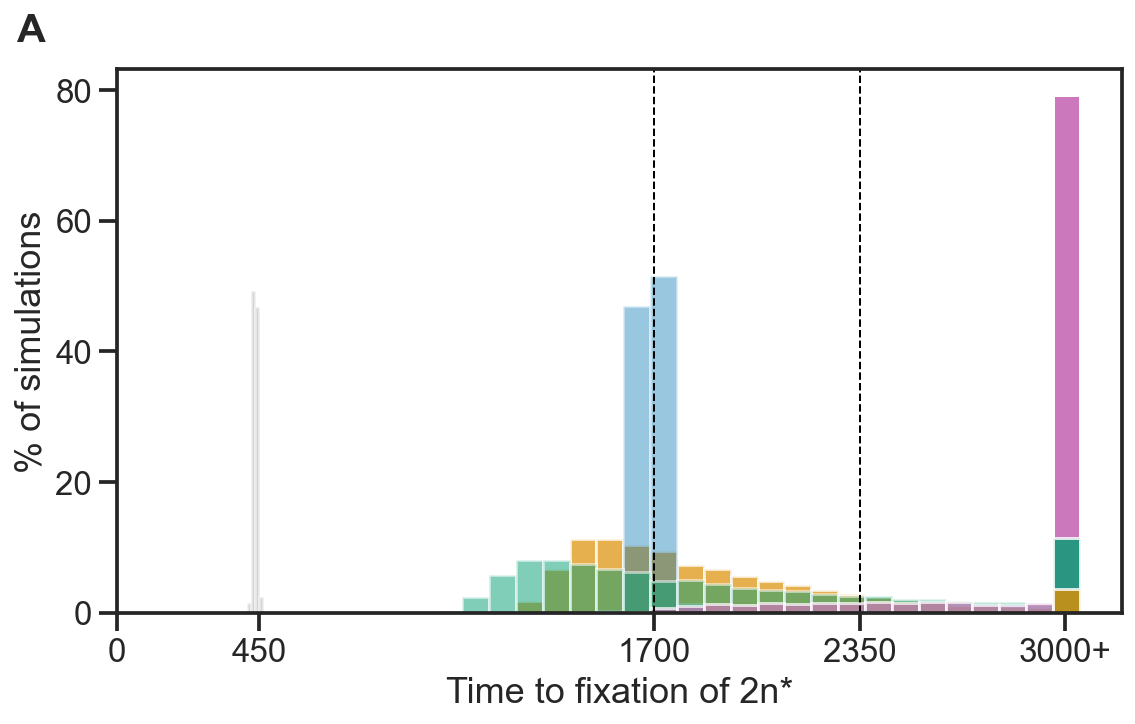

In [67]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 2.5, 'lines.markersize': 7})
blue,yellow,green,red,pink,brown,pink2,grey = sns.color_palette("colorblind", 8)

def plot(withaneuploidy, withaneuploidy_delta0, no_aneuploidy, extended_priors, neutral_aneuploidy, bins, norm_hist, stopon=10000, reps=10_000):
    if withaneuploidy is not None:
        times,p = withaneuploidy
        nparr = np.array(p)
        l = nparr[:,1][:,].shape[1]
        trifixtimes = [next((i for i,p in enumerate(nparr[:,1][:,j]) if p>=0.95),stopon) for j in  range(l)]

        a1 = l-len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus>450])
        a2 = len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus<=1700 and plus>450])
        a3 = len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus<=2350 and plus>1700])
        a4 = len([(tri,plus) for plus, tri in zip(times,trifixtimes) if tri<=450 and tri>200 and plus>2350])
        print('no trisomy at 450:', a1,'of ',l)
        print('450<F<1700',a2)
        print('1700<F<2350',a3)
        print('F>2350',a4)
        print('test:',l-a2-a3-a4==a1)

    plt.subplots(figsize=(9, 5))
    ax = plt.axes()
    
    if neutral_aneuploidy is not None:
        sns.distplot([t for t in neutral_aneuploidy[0] if t<stopon], rug=False, 
                    kde=False,ax=ax,color=yellow,bins=bins[1], 
                rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist, label='Neutral aneuploidy model MAP'
                    ,hist_kws=dict(alpha=0.7))
    if withaneuploidy is not None:
        sns.distplot([plus for plus, tri in zip(times,trifixtimes) if tri<=450 and plus>450 and plus<stopon], rug=False, 
                     kde=False,ax=ax,color=blue,bins=bins[0], 
                    rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist, label='With aneuploidy model MAP')
    if no_aneuploidy is not None:
        sns.distplot([t for t in no_aneuploidy[0] if t<stopon], rug=False, 
                    kde=False,ax=ax,color=green,bins=bins[1], 
                rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist, label='No aneuploidy model MAP',
                    hist_kws=dict(alpha=0.5))
    if extended_prior is not None:
        b = [t for t in extended_prior[0] if t<stopon]
        b = [b for b in b if b<2999]
        sns.distplot(b, rug=False, 
                    kde=False,ax=ax,color=pink,bins=bins[1], 
                rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist, label='Extended prior model MAP'
                    ,hist_kws=dict(alpha=0.7))
    if withaneuploidy_delta0 is not None:
        sns.distplot([t for t in withaneuploidy_delta0[0] if t<stopon], rug=False, 
                kde=False,ax=ax,color=grey,bins=bins[2], 
            rug_kws={"color": "gray","height":"0.03"}, norm_hist=norm_hist, 
                     label='With aneuploidy model MAP, $\delta=0$')
        
    ## last bar
    if extended_prior is not None:
        b = [t for t in extended_prior[0] if t<stopon]
        b = [b for b in b if b==2999]
        sns.distplot(b, rug=False, 
                    kde=False,ax=ax,color=pink,bins=bins[1], 
                        rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist,
                                        hist_kws=dict(alpha=1))
    if no_aneuploidy is not None:
        b = [t for t in no_aneuploidy[0] if t<stopon]
        b = [b for b in b if b==2999]
        sns.distplot(b, rug=False, 
                    kde=False,ax=ax,color=green,bins=bins[1], 
                rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist,
                    hist_kws=dict(alpha=0.8))
    if neutral_aneuploidy is not None:
        b = [t for t in neutral_aneuploidy[0] if t<stopon]
        b = [b for b in b if b==2999]
        sns.distplot(b, rug=False, 
                    kde=False,ax=ax,color=yellow,bins=bins[1], 
                rug_kws={"color": "gray","height":"0.03"},norm_hist=norm_hist,
                    hist_kws=dict(alpha=0.8))
        
    ax.axvline(1700,color='black',linestyle='--',linewidth=1)
    ax.axvline(2350,color='black',linestyle='--',linewidth=1)
    
    ax.set(xlabel='Time to fixation of 2n*', 
           ylabel='% of simulations')
    
#     plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.75), fontsize=16)

    ax.set_xticks([0,450,1700,2350,3000])
    ax.set_xticklabels([0,450,1700,2350,'3000+'])
    ax.set_xlim(left = 0) # is it good to start from 0?
    ax.set_yticklabels((100*ax.get_yticks()/reps).astype(int)) # convert to percents
    ax.text(-0.1, 1.05, 'A', transform=ax.transAxes, size=20, weight='bold')
    
b = [t for t in no_aneuploidy[0]]
c = [t for t in with_aneuploidy_delta0[0]]
minn = int(min(min(b),min(c)))
maxx = int(max(max(b),max(c)))
width = 85
bins = list(range(minn,maxx+width,width))
plot(with_aneuploidy, with_aneuploidy_delta0, no_aneuploidy, extended_prior, neutral_aneuploidy, [bins,bins,4, bins, bins], False, stopon=3000)
plt.gcf().savefig(f'{output_path}/fixation-plot-a.pdf', bbox_inches='tight')

## another figure

In [68]:
reps = 10000
times, p = with_aneuploidy
fixation_progress_with = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,3][:3000,]]
if len(fixation_progress_with)!=3000:
    fixation_progress_with = fixation_progress_with+[fixation_progress_with[-1]]*(3000-len(fixation_progress_with))

In [69]:
times, p = no_aneuploidy
fixation_progress_without = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,3][:3000,]]
if len(fixation_progress_without)!=3000:
    fixation_progress_without = fixation_progress_without+[fixation_progress_without[-1]]*(3000-len(fixation_progress_without))

In [70]:
times, p = extended_prior
fixation_progress_extended = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,3][:3000,]]
if len(fixation_progress_extended)!=3000:
    fixation_progress_extended = fixation_progress_extended+[fixation_progress_extended[-1]]*(3000-len(fixation_progress_extended))

In [71]:
times, p = neutral_aneuploidy
fixation_progress_neutral = [len([b for b in a if b>0.95])/reps for a in np.array(p)[:,3][:3000,]]
if len(fixation_progress_neutral)!=3000:
    fixation_progress_neutral = fixation_progress_neutral+[fixation_progress_neutral[-1]]*(3000-len(fixation_progress_neutral))

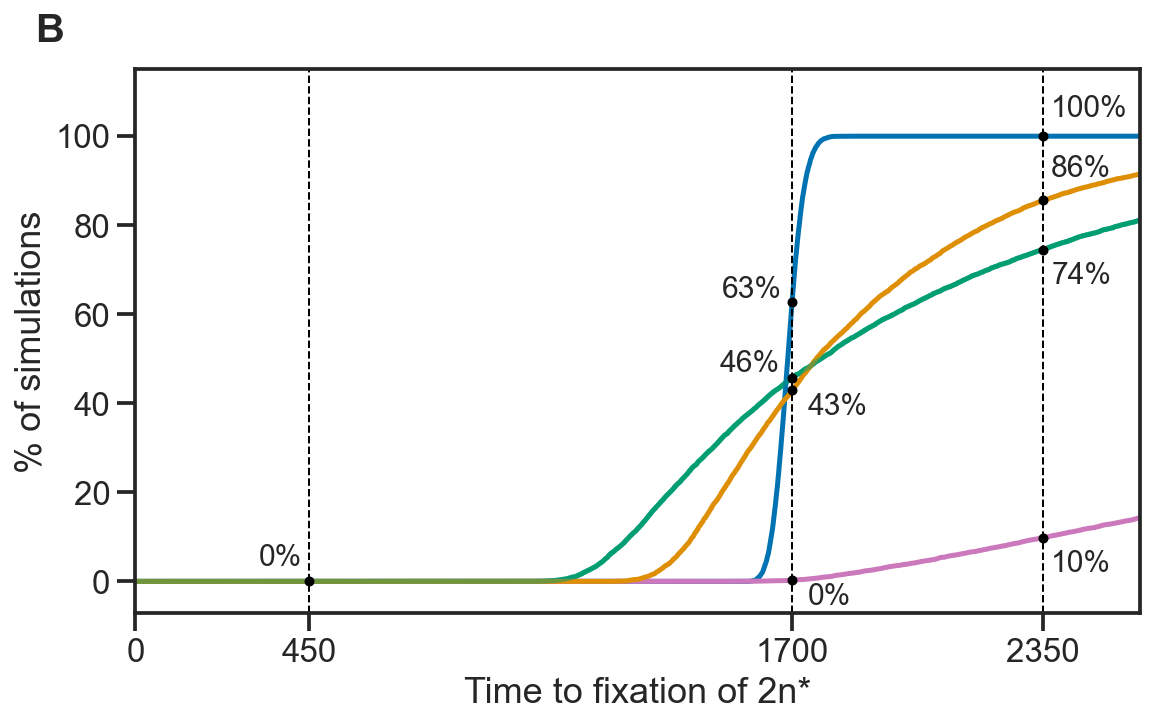

In [72]:
import seaborn as sns

blue,yellow,green,red,pink,brown,pink2,grey = sns.color_palette("colorblind", 8)

def plot_accumulated_fixation(progress, progress2, progress3, progress4):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(range(len(progress2)), progress2, label='No aneuploidy model MAP', color=green)
    ax.plot(range(len(progress)), progress, label='With aneuploidy model MAP', color=blue)
    ax.plot(range(len(progress3)), progress3, color=pink)
    ax.plot(range(len(progress3)), progress4, color=yellow)
    ax.plot(range(len(progress2)), progress2, color=green, alpha=0.5)
    

    ax.axvline(450,linestyle='--',linewidth=1,color="black")
    ax.axvline(1700,linestyle='--',linewidth=1,color="black")
    ax.axvline(2350,linestyle='--',linewidth=1,color="black")
       
    annot_font_size = 15
    plt.plot(450,progress[450],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress[450]*100),(450,progress[450]),(-25,8),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(1700,progress[1700],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress[1700]*100),(1700,progress[1700]),(-35,2),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(2350,progress[2350],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress[2350]*100),(2350,progress[2350]),(4,10),textcoords='offset points',fontsize=annot_font_size)
    
    plt.plot(1700,progress2[1700],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress2[1700]*100),(1700,progress2[1700]),(-36,3),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(2350,progress2[2350],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress2[2350]*100),(2350,progress2[2350]),(4,-17),textcoords='offset points',fontsize=annot_font_size)

    plt.plot(1700,progress3[1700],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress3[1700]*100),(1700,progress3[1700]),(8,-12),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(2350,progress3[2350],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress3[2350]*100),(2350,progress3[2350]),(4,-17),textcoords='offset points',fontsize=annot_font_size)
    
    plt.plot(1700,progress4[1700],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress4[1700]*100),(1700,progress4[1700]),(8,-12),textcoords='offset points',fontsize=annot_font_size)
    plt.plot(2350,progress4[2350],'o',color='black')
    plt.annotate('{:.0f}%'.format(progress4[2350]*100),(2350,progress4[2350]),(4,12),textcoords='offset points',fontsize=annot_font_size)
    
    plt.xlim(0,2600)
    plt.ylim(-0.07,1.15)
    
    import matplotlib.ticker as mtick
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_yticklabels([int(a) for a in 100*ax.get_yticks()]) # convert to percents
    ax.set_xticks([0,450,1700,2350])

    ax.set(xlabel='Time to fixation of 2n*', ylabel='% of simulations')
#     plt.legend(*(
#         [ x[i] for i in [1,0] ]
#         for x in plt.gca().get_legend_handles_labels()),
#                loc='upper right', bbox_to_anchor=(1.55, 0.75), fontsize=16)
    
    ax.text(-0.1, 1.05, 'B', transform=ax.transAxes, size=20, weight='bold')

    
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 2.5, 'lines.markersize': 4})

plot_accumulated_fixation(fixation_progress_with, fixation_progress_without, fixation_progress_extended, 
                          fixation_progress_neutral)
plt.gcf().savefig(f'{output_path}/fixation-plot-b.pdf', bbox_inches='tight',)